In [2]:
import numpy as np
import os
import pandas as pd
import xarray as xr
import netCDF4
import pytz # for converting era5 utc time to est time
from scipy.spatial import cKDTree # for finding nearest points to each other
from scipy.spatial import KDTree  # another one for finding distances from points 
from datetime import datetime, timedelta # for getting hourly mean radiation values from accumulations
import rasterio # for opening tiles to get coordinates
from pyproj import Transformer # for getting coordinates of tiles 


In [175]:

# read in the sensor network data and the ERA5 data
sensor_network_data = pd.read_csv(r"C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\july_aug_mean.csv" )
era5_ds = xr.open_dataset(r'C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\durham_era5_JA_24.nc')
# Convert era5 ds to a dataframe
era5_df = era5_ds.to_dataframe().reset_index()

july_era5_land_ds = xr.open_dataset(r'C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\durham_era5_land_july24.nc')
august_era5_land_ds = xr.open_dataset(r'C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\durham_era5_land_august24.nc')
era5_land_ds = xr.merge([july_era5_land_ds, august_era5_land_ds])
# Convert era5 land ds to a dataframe
era5_land_df = era5_land_ds.to_dataframe().reset_index()

## convert all the temperatures to celcius
# from K for era5
era5_df['d2m'] = era5_df['d2m'] -273.15
era5_df['t2m'] = era5_df['t2m'] -273.15
era5_land_df['d2m'] = era5_land_df['d2m'] -273.15
era5_land_df['t2m'] = era5_land_df['t2m'] -273.15
# from fahrenheit for sensor network
sensor_network_data['predictions'] = 5/9*(sensor_network_data['predictions'] - 32)

## get rh from era5 dew point and air temperatures
def calculate_relative_humidity(t2m, d2m):
    """
    calculate relative humidity from 2m air and dew point temps
    August-Roche-Magnus equation (https://doi.org/10.5194/tc-2023-8)
        t2m: 2m air temp in degC
        d2m: 2m dew point temp in degC
        
        return: relative humidity in %
    """
    # Calculate saturation vapor pressure (e_s) for air temp
    if t2m > 0:
        e_s = 6.11 * np.exp((17.62 * t2m) / (t2m + 243.12))
    else:
        e_s = 6.11 * np.exp((22.46 * t2m) / (t2m + 272.62))
    
    # Calculate actual vapor pressure (e_d) for dew point temp
    if d2m > 0:
        e_d = 6.11 * np.exp((17.62 * d2m) / (d2m + 243.12))
    else:
        e_d = 6.11 * np.exp((22.46 * d2m) / (d2m + 272.62))
    
    # Calculate relative humidity
    rh = 100 * (e_d / e_s)
    
    return rh

era5_df['rh'] = era5_df.apply(lambda row: calculate_relative_humidity(row['t2m'], row['d2m']), axis=1)
era5_land_df['rh'] = era5_land_df.apply(lambda row: calculate_relative_humidity(row['t2m'], row['d2m']), axis=1)

# convert the era5 time to EST
# Define the EST timezone
est = pytz.timezone('US/Eastern')
# Localize the datetime to UTC 
era5_df['valid_time'] = era5_df['valid_time'].dt.tz_localize('UTC')
era5_df['est_time'] = era5_df['valid_time'].dt.tz_convert(est)
era5_df['est_time'] = era5_df['est_time'].dt.tz_localize(None)

era5_land_df['valid_time'] = era5_land_df['valid_time'].dt.tz_localize('UTC')
era5_land_df['est_time'] = era5_land_df['valid_time'].dt.tz_convert(est)
era5_land_df['est_time'] = era5_land_df['est_time'].dt.tz_localize(None)

# set the era5 land to start from UTC 1, otherwise cannot get the previous hours accumulation if starting from 00
era5_land_df = era5_land_df[12:].reset_index(drop = True)

# convert the era5 land ssrd and strd into the hourly values, more complicated than with era5 as have to deal with accumumations
# each value represents the accumulated values for the day, so have to take off prev hours accumulation (apart from for 00-01 i.e. hour 1)

for i in range(len(era5_land_df)):
    if era5_land_df.iloc[i]['valid_time'].hour == 1:
        era5_land_df.loc[i, 'ssrd2'] = era5_land_df.iloc[i].ssrd / 3600
        era5_land_df.loc[i, 'strd2'] = era5_land_df.iloc[i].strd / 3600
    else:
        lat = era5_land_df.iloc[i].latitude 
        lon = era5_land_df.iloc[i].longitude 
        hour_before = era5_land_df.iloc[i]['valid_time'] - timedelta(hours=1)
        previous_accumulation_ssrd = era5_land_df[(era5_land_df.latitude == lat)&(era5_land_df.longitude == lon)&(
                                                                era5_land_df.valid_time == hour_before)].ssrd
        previous_accumulation_strd = era5_land_df[(era5_land_df.latitude == lat)&(era5_land_df.longitude == lon)&(
                                                                era5_land_df.valid_time == hour_before)].strd
        if len(previous_accumulation_ssrd.values) != 1:
            print(len(previous_accumulation_ssrd.values),'values for index', i)
        era5_land_df.loc[i, 'ssrd2'] = (era5_land_df.iloc[i].ssrd - previous_accumulation_ssrd.values)/ 3600
        era5_land_df.loc[i, 'strd2'] = (era5_land_df.iloc[i].strd - previous_accumulation_strd.values)/ 3600

# some very small negative values due to rounding, set these to zero
era5_land_df.loc[era5_land_df.ssrd2 < 0, 'ssrd2'] = 0
# none of the strd were neg so don't really need this 
#era5_land_df.loc[era5_land_df.strd2 < 0, 'strd2'] = 0 

print('Lon Bounds', sensor_network_data.x.min(), sensor_network_data.x.max())
print('Lat Bounds', sensor_network_data.y.min(), sensor_network_data.y.max())

Lon Bounds -79.0158 -78.7464
Lat Bounds 35.8593 36.1452


In [202]:
## get the max daily values for the era5 
era5_df['Date'] = era5_df['est_time'].dt.date # first extract the date
max_daily_temps = era5_df.groupby(['latitude','longitude','Date']).max(numeric_only = True).reset_index(
    )[['latitude','longitude','Date','t2m']].rename(columns = {'t2m':'max_t2m'})
# add back into the main df to find out the values of other variables when the max temp occurs
era5_df = era5_df.merge(max_daily_temps, on = ['latitude','longitude','Date'], how = 'left')
# get only the maximum daily temperatures and add in the time it occurs
max_temp_df = era5_df[era5_df.t2m == era5_df.max_t2m].reset_index(drop = True).copy()
max_temp_df['Time'] = max_temp_df.est_time.dt.time

temp_peaking_times = max_temp_df[['Time','valid_time']].groupby('Time').count().reset_index().rename(columns = {'valid_time':'day_count'})
## the max temps tend to occur at 16:00 to 17:00
print('ERA5 times when the max temp occurs',temp_peaking_times)
# get the July August means
mean_max_temp_df = max_temp_df.groupby(['latitude','longitude']).mean(numeric_only = True).reset_index()

#J m-2 to W m-2 converion - divide joules by time in seconds to get watts 
mean_max_temp_df['ssrd'] = mean_max_temp_df['ssrd']/3600    # shortwave radiation kdown
mean_max_temp_df['strd'] = mean_max_temp_df['strd']/3600    # longwave radiation (thermal) ldown

## rename for clarity
## era5 dataset
mean_max_temp_df = mean_max_temp_df.rename(columns = {'latitude':'era5_lat','longitude':'era5_lon','t2m':'era5_air_temp','rh':'era5_rh',
                                   'ssrd':'shortwave_radiation', 'strd':'longwave_radiation'})


## get the max daily values for the era5 land
era5_land_df['Date'] = era5_land_df['est_time'].dt.date # first extract the date
era5_land_max_daily_temps = era5_land_df.groupby(['latitude','longitude','Date']).max(numeric_only = True).reset_index(
    )[['latitude','longitude','Date','t2m']].rename(columns = {'t2m':'max_t2m'})
# add back into the main df to find out the values of other variables when the max temp occurs
era5_land_df = era5_land_df.merge(era5_land_max_daily_temps, on = ['latitude','longitude','Date'], how = 'left')
# get only the maximum daily temperatures and add in the time it occurs
era5_land_max_temp_df = era5_land_df[era5_land_df.t2m == era5_land_df.max_t2m].reset_index(drop = True).copy()
era5_land_max_temp_df['Time'] = era5_land_max_temp_df.est_time.dt.time

temp_peaking_times = era5_land_max_temp_df[['Time','valid_time']].groupby('Time').count().reset_index().rename(columns = {'valid_time':'day_count'})
## the max temps tend to occur at 16:00 to 17:00
print('ERA5 Land times when the max temp occurs',temp_peaking_times)
# get the July August means
era5_land_mean_max_temp_df = era5_land_max_temp_df.groupby(['latitude','longitude']).mean(numeric_only = True).reset_index()

#J m-2 to W m-2 converion - divide joules by time in seconds to get watts 
# for era5 land, accumulations are from 00 UTC to the hour ending at the forecast step, and this was dealt with previously (ssrd2, strd2)
# so don't need to do the conversion here, but need to take ssrd2 and strd2 

## rename for clarity
## era5 dataset
era5_land_mean_max_temp_df = era5_land_mean_max_temp_df.rename(columns = {'latitude':'era5_land_lat','longitude':'era5_land_lon',
                                                                          't2m':'era5_land_air_temp','rh':'era5_land_rh',
                                   'ssrd2':'era5_land_shortwave_radiation', 'strd2':'era5_land_longwave_radiation'})

## sensor network dataset
## renaming for clarity
sensor_network_data = sensor_network_data.rename(columns = {'y':'network_lat', 'x':'network_lon', 'predictions':'network_air_temp'})

## merge the data by adding the closest era5 data to the sensor network datapoints
# Create KDTree for the era5 coordinates
tree = cKDTree(mean_max_temp_df[['era5_lat', 'era5_lon']])

# Query the nearest neighbors for the sensor network dataset
distances, indices = tree.query(sensor_network_data[['network_lat', 'network_lon']], k=1)

# Add nearest data from era5 to the sensor network points
# add to coords
sensor_network_data['era5_lat'] = mean_max_temp_df.iloc[indices]['era5_lat'].values
sensor_network_data['era5_lon'] = mean_max_temp_df.iloc[indices]['era5_lon'].values
# add the rest of the met data
sensor_network_data = sensor_network_data.merge(mean_max_temp_df[['era5_lat','era5_lon','era5_air_temp','shortwave_radiation','longwave_radiation',
                                            'era5_rh']], on = ['era5_lat','era5_lon'], how = 'left')

# add era5 land into the sensor network dataset
# Create KDTree for the era5 coordinates
tree = cKDTree(era5_land_mean_max_temp_df[['era5_land_lat', 'era5_land_lon']])

# Query the nearest neighbors for the sensor network dataset
distances, indices = tree.query(sensor_network_data[['network_lat', 'network_lon']], k=1)

# Add nearest data from era5 to the sensor network points
# add to coords
sensor_network_data['era5_land_lat'] = era5_land_mean_max_temp_df.iloc[indices]['era5_land_lat'].values
sensor_network_data['era5_land_lon'] = era5_land_mean_max_temp_df.iloc[indices]['era5_land_lon'].values
# add the rest of the met data
sensor_network_data = sensor_network_data.merge(era5_land_mean_max_temp_df[['era5_land_lat','era5_land_lon','era5_land_air_temp',
                                                                    'era5_land_shortwave_radiation','era5_land_longwave_radiation',
                                                                        'era5_land_rh']], on = ['era5_land_lat', 'era5_land_lon'], how = 'left')



# save as pickle
sensor_network_data.to_pickle(r'C:\Users\UEA_Laptop\Documents\Python_Scripts\DDL\SOLWEIG\met_data.pkl')  

ERA5 times when the max temp occurs        Time  day_count
0  11:00:00          2
1  12:00:00          7
2  13:00:00          9
3  14:00:00         38
4  15:00:00         49
5  16:00:00         67
6  17:00:00         70
7  18:00:00          6
8  20:00:00          4
ERA5 Land times when the max temp occurs         Time  day_count
0   00:00:00         12
1   11:00:00         28
2   12:00:00         21
3   13:00:00         14
4   14:00:00        192
5   15:00:00        144
6   16:00:00        229
7   17:00:00        101
8   18:00:00          2
9   19:00:00          1
10  21:00:00         12


In [3]:
# load pickle
sensor_network_data = pd.read_pickle(r'C:\Users\UEA_Laptop\Documents\Python_Scripts\DDL\SOLWEIG\met_data.pkl')  

In [6]:
def get_tif_center_coords(tif_file):
    """
    Convert the center coordinates of a GeoTIFF from NAD83 (2011) to latitude and longitude (WGS84).

    Parameters:
        tif_file (str): Path to the GeoTIFF file.

    Returns:
        tuple: (latitude, longitude) coordinates of the center in WGS84.
    """
    with rasterio.open(tif_file) as src:
        # Get the bounds of the GeoTIFF
        bounds = src.bounds
        # Calculate the center in the original CRS
        center_x = (bounds.left + bounds.right) / 2
        center_y = (bounds.bottom + bounds.top) / 2

        # Define the transformer for NAD83 (2011) to WGS84
        transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)

        # Transform the center coordinates
        center_lon, center_lat = transformer.transform(center_x, center_y)

    return center_lat, center_lon
    
# find the nearest point to the tile
# function to calculate the nearest point
# Convert lat/lon to Cartesian coordinates for KDTree (using Haversine projection approximation)
def latlon_to_cartesian(lat, lon):
    # Convert degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Earth radius in meters
    R = 6371000
    x = R * np.cos(lat_rad) * np.cos(lon_rad)
    y = R * np.cos(lat_rad) * np.sin(lon_rad)
    z = R * np.sin(lat_rad)
    return np.array([x, y, z])

In [17]:
# Define Earth's approximate radius in kilometers
EARTH_RADIUS_KM = 6371.0

# Function to calculate degree differences for a given distance
def distance_to_degrees_km(distance_km, latitude):
    # 1 degree latitude is approximately 111 km
    lat_degree = distance_km / 111.0
    # 1 degree longitude varies with latitude
    lon_degree = distance_km / (111.0 * np.cos(np.radians(latitude)))
    return lat_degree, lon_degree


In [18]:
#######################################################################################################
############### Code that gets the mean of the bounding box around the centre coords ##################
#######################################################################################################

dsm_folder ='D:/laz_format_files_Durham_whole_area_2015/Central_Tiles/Classifications/Meters/DSM/tiles_1kby1k_150buffer'

file_name_list = []
for file_name in os.listdir(dsm_folder):
    if file_name.endswith(".tif"):
        file_name_list.append(file_name)

for filename in file_name_list:

    tif_path = os.path.join(dsm_folder, filename)
    tile_name = filename[4:-4]
    center_coords = get_tif_center_coords(tif_path)

    tile_lat = center_coords[0]
    tile_lon = center_coords[1]

    # Calculate degree range for 1 km box
    box_lat_range, box_lon_range = distance_to_degrees_km(0.5, tile_lat)  # 0.5 km on each side

    # Define the box boundaries
    min_lat = tile_lat - box_lat_range
    max_lat = tile_lat + box_lat_range
    min_lon = tile_lon - box_lon_range
    max_lon = tile_lon + box_lon_range

    # Filter points within the box
    points_within_box = sensor_network_data[
        (sensor_network_data['network_lat'] >= min_lat) & 
        (sensor_network_data['network_lat'] <= max_lat) & 
        (sensor_network_data['network_lon'] >= min_lon) & 
        (sensor_network_data['network_lon'] <= max_lon)
        ]

    for air_temp_source in ['Sensor_Network', 'ERA5_Land']:
        if air_temp_source == 'Sensor_Network': 
            tair = points_within_box.network_air_temp.mean()    
        elif air_temp_source == 'ERA5_Land':
            tair = points_within_box.era5_land_air_temp.mean()
        else:
            print('Specify the air temperature data source')

        rh = points_within_box.era5_land_rh.mean()
        kdown = points_within_box.era5_land_shortwave_radiation.mean()
        ldown = points_within_box.era5_land_longwave_radiation.mean()

        # write the required data into a 
        data = {
            '%iy': [2024, 2024],
            'id': [214, 214],
            'it': [16, 17],
            'imin': [0, 0],
            'Q*':[-999.00,-999.00],
            'QH':[-999.00,-999.00],
            'QE':[-999.00,-999.00],
            'Qs':[-999.00,-999.00],
            'Qf':[-999.00,-999.00],
            'Wind':[-999.00,-999.00],
            'RH': [rh ,rh],
            'Td': [tair, tair],
            'press':[-999.00,-999.00],
            'rain':[-999.00,-999.00],
            'Kdn': [kdown,kdown],
            'snow':[-999.00,-999.00],
            'ldown': [ldown, ldown],
            'fcld':[-999.00,-999.00],
            'wuh':[-999.00,-999.00],
            'xsmd':[-999.00,-999.00],
            'lai_hr':[-999.00,-999.00],
            'Kdiff':[-999.00,-999.00],
            'Kdir':[-999.00,-999.00],
            'Wd':[-999.00,-999.00]
        }

        # Create a DataFrame
        df = pd.DataFrame(data)

        # Write to a text file with space-separated values
        output_file = r"C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_{}_{}.txt".format(air_temp_source, tile_name)
        df.to_csv(output_file, sep=' ', index=False)

        # Print confirmation
        print(f"Data written to {output_file}")

Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_Sensor_Network_Job1021395_35078_95_88_tile_0_0.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_ERA5_Land_Job1021395_35078_95_88_tile_0_0.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_Sensor_Network_Job1021395_35078_95_88_tile_0_1.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_ERA5_Land_Job1021395_35078_95_88_tile_0_1.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_Sensor_Network_Job1021395_35078_95_88_tile_0_10.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_ERA5_Land_Job1021395_35078_95_88_tile_0_10.txt
Data written to C

In [204]:
#########################################################################################
############### Code that gets nearest point to the centre coordinates ##################
#########################################################################################

dsm_folder ='D:/laz_format_files_Durham_whole_area_2015/Central_Tiles/Classifications/Meters/DSM/tiles_1kby1k_150buffer'

file_name_list = []
for file_name in os.listdir(dsm_folder):
    if file_name.endswith(".tif"):
        file_name_list.append(file_name)

for filename in file_name_list:

    tif_path = os.path.join(dsm_folder, filename)
    tile_name = filename[4:-4]
    center_coords = get_tif_center_coords(tif_path)

    tile_lat = center_coords[0]
    tile_lon = center_coords[1]

    ## for each of the tiles, get the coordinates and retrive the nearest point
    # Prepare KDTree with DataFrame points
    points_cartesian = np.array([latlon_to_cartesian(lat, lon) for lat, lon in zip(sensor_network_data['network_lat'], sensor_network_data['network_lon'])])
    tree = KDTree(points_cartesian)

    # Convert the given point to Cartesian coordinates
    tile_points_cartesian = latlon_to_cartesian(tile_lat, tile_lon)

    # Query the nearest neighbor
    distance, index = tree.query(tile_points_cartesian)

    # Retrieve the nearest point's data
    nearest_point = sensor_network_data.iloc[index]

    for air_temp_source in ['Sensor_Network', 'ERA5_Land']:
        if air_temp_source == 'Sensor_Network': 
            tair = nearest_point.network_air_temp    
        elif air_temp_source == 'ERA5_Land':
            tair = nearest_point.era5_land_air_temp
        else:
            print('Specify the air temperature data source')

        rh = nearest_point.era5_land_rh
        kdown = nearest_point.era5_land_shortwave_radiation
        ldown = nearest_point.era5_land_longwave_radiation

        # write the required data into a 
        data = {
            '%iy': [2024, 2024],
            'id': [214, 214],
            'it': [16, 17],
            'imin': [0, 0],
            'Q*':[-999.00,-999.00],
            'QH':[-999.00,-999.00],
            'QE':[-999.00,-999.00],
            'Qs':[-999.00,-999.00],
            'Qf':[-999.00,-999.00],
            'Wind':[-999.00,-999.00],
            'RH': [rh ,rh],
            'Td': [tair, tair],
            'press':[-999.00,-999.00],
            'rain':[-999.00,-999.00],
            'Kdn': [kdown,kdown],
            'snow':[-999.00,-999.00],
            'ldown': [ldown, ldown],
            'fcld':[-999.00,-999.00],
            'wuh':[-999.00,-999.00],
            'xsmd':[-999.00,-999.00],
            'lai_hr':[-999.00,-999.00],
            'Kdiff':[-999.00,-999.00],
            'Kdir':[-999.00,-999.00],
            'Wd':[-999.00,-999.00]
        }

        # Create a DataFrame
        df = pd.DataFrame(data)

        # Write to a text file with space-separated values
        output_file = r"C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_{}_{}.txt".format(air_temp_source, tile_name)
        df.to_csv(output_file, sep=' ', index=False)

        # Print confirmation
        print(f"Data written to {output_file}")

Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_Sensor_Network_Job1021395_35078_95_88_tile_0_0.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_ERA5_Land_Job1021395_35078_95_88_tile_0_0.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_Sensor_Network_Job1021395_35078_95_88_tile_0_1.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_ERA5_Land_Job1021395_35078_95_88_tile_0_1.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_Sensor_Network_Job1021395_35078_95_88_tile_0_10.txt
Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\By_tile\output_met_data_ERA5_Land_Job1021395_35078_95_88_tile_0_10.txt
Data written to C

MemoryError: Unable to allocate 176. MiB for an array with shape (7702146, 3) and data type float64

In [97]:
nearest_point

row                              1432.000000
col                              1017.000000
network_lon                       -78.914200
network_lat                        36.004100
network_air_temp                   31.484380
era5_lat                           36.100000
era5_lon                          -79.010000
era5_air_temp                      30.202085
shortwave_radiation               577.682373
longwave_radiation                418.506744
era5_rh                            58.033799
era5_land_lat                      36.050000
era5_land_lon                     -78.910000
era5_land_air_temp                 29.955700
era5_land_shortwave_radiation    4023.876465
era5_land_longwave_radiation     7502.575195
era5_land_rh                       58.949084
Name: 3799555, dtype: float64

In [85]:
#network air temperature = 31.5
#ERA5 air temperature = 30.2

SyntaxError: invalid syntax (208525977.py, line 1)

In [86]:
tile_name = 'tile_5_6'
#air_temp_source = 'Sensor_Network'
air_temp_source = 'ERA5'


if air_temp_source == 'Sensor_Network': 
    tair = nearest_point.network_air_temp    
elif air_temp_source == 'ERA5':
    tair = nearest_point.era5_air_temp
else:
    print('Specify the air temperature data source')

rh = nearest_point.era5_rh
kdown = nearest_point.shortwave_radiation
ldown = nearest_point.longwave_radiation

# write the required data into a 
data = {
    '%iy': [2024, 2024],
    'id': [214, 214],
    'it': [16, 17],
    'imin': [0, 0],
    'Q*':[-999.00,-999.00],
    'QH':[-999.00,-999.00],
    'QE':[-999.00,-999.00],
    'Qs':[-999.00,-999.00],
    'Qf':[-999.00,-999.00],
    'Wind':[-999.00,-999.00],
    'RH': [rh ,rh],
    'Td': [tair, tair],
    'press':[-999.00,-999.00],
    'rain':[-999.00,-999.00],
    'Kdn': [kdown,kdown],
    'snow':[-999.00,-999.00],
    'ldown': [ldown, ldown],
    'fcld':[-999.00,-999.00],
    'wuh':[-999.00,-999.00],
    'xsmd':[-999.00,-999.00],
    'lai_hr':[-999.00,-999.00],
    'Kdiff':[-999.00,-999.00],
    'Kdir':[-999.00,-999.00],
    'Wd':[-999.00,-999.00]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Write to a text file with space-separated values
output_file = r"C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\output_met_data_{}_{}.txt".format(air_temp_source, tile_name)
df.to_csv(output_file, sep=' ', index=False)

# Print confirmation
print(f"Data written to {output_file}")


Data written to C:\Users\UEA_Laptop\Documents\DDL\Science_Projects\SOLWEIG\Durham\Met_Data\output_met_data_ERA5_tile_5_6.txt


In [ ]:
##############################################
############# Creating Plots #################
##############################################

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [5]:
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL','Sensor_Network'))

durham_boundary = pd.read_csv(r'C:\Users\UEA_Laptop\Documents\Python_Scripts\DDL\Sensor_Network\Durham_boundary_csv.csv')
# extract geometry
shapefiles = pd.DataFrame()
for i in durham_boundary['.geo'].values:
    shapefile = gpd.read_file(i)
    shapefiles = pd.concat([shapefiles, shapefile])

In [6]:
shapefiles

,geometry
0,GEOMETRYCOLLECTION (LINESTRING (-78.9789 35.89...


In [ ]:
####################################################################
###################### ERA5 Durham Data ############################
####################################################################

fig, axes = plt.subplots(1,1, figsize=(10, 8))

#fig.suptitle('Daytime Mean Air Temperature, July August', fontsize=16, y = 0.92)

# mean overall values (remove week grouping)

# create the colormap
scale_min = 27
scale_max = 31
cmap = plt.cm.Reds  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 17)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 5)

p = gpd.GeoSeries(shapefiles.geometry[0])
#p.plot()

im1 = p.plot(linewidth=0.4, ax = axes, facecolor='none',edgecolor=".4")

landcover_types = ['impervious', 'vegetation']
shading_types = ['shaded','non-shaded']

#legend_labels = []
#legend_markers = []

for landcover_type in landcover_types:
    for shading_type in shading_types:
        sensor_data_to_plot3 = sensor_data_to_plot2[(sensor_data_to_plot2['Shade Type'] == shading_type)&(
            sensor_data_to_plot2['Landcover Type'] == landcover_type)]
        # set marker style depending on shading type
        if (shading_type == 'shaded')&(landcover_type == 'impervious'):
            markerstyle = '^'
        elif (shading_type == 'non-shaded')&(landcover_type == 'impervious'): 
            markerstyle = 'o'
        elif (shading_type == 'shaded')&(landcover_type == 'vegetation'): 
            markerstyle = '<'
        elif (shading_type == 'non-shaded')&(landcover_type == 'vegetation'): 
            markerstyle = 's'
        
        # set outline color depending on landcover type - this looks strange with the cmap
        #if landcover_type == 'impervious':
        #    edgecolor = 'grey'
        #else: 
        #    edgecolor = 'green'
            
        
        axes.scatter(sensor_data_to_plot3.x, sensor_data_to_plot3.y, c= sensor_data_to_plot3.Temperature, cmap = cmap, norm = norm,
                     label = '{} {}'.format(landcover_type, shading_type) , marker = markerstyle  )

        #legend_labels.append('{} {}'.format(landcover_type, shading_type) )
        #legend_markers.append(markerstyle)


# dont want a box round the map
axes.axis("off")
axes.legend(fontsize = 12)

# Set the color of all legend markers to a single color (e.g., red)
#for legend_handle in legend.legend_handles:
#    legend_handle.set_color('red')
#    legend_handle.set_markerfacecolor('red')
## shaded vs unshaded- shape? 
## impervious = grey outline, vegetation = green outline 

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.04, pad=0.04, 
                    ticks =bounds_for_colorbar)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label= 'Air Temperature (\u00b0C)', size=12)

#plt.savefig('durham_shape_w_sensors_day.png',bbox_inches='tight',facecolor='w')#, transparent = True)

In [158]:
mean_max_temp_df

,era5_lat,era5_lon,number,d2m,era5_air_temp,shortwave_radiation,longwave_radiation,era5_rh,max_t2m
0,35.85,-79.01,0.0,20.663273,30.532461,577.472168,419.526611,57.263193,30.532461
1,35.85,-78.76,0.0,20.798021,30.487810,587.302429,420.049469,57.748639,30.487810
2,36.10,-79.01,0.0,20.567259,30.202085,577.682373,418.506744,58.033799,30.202085
3,36.10,-78.76,0.0,20.694714,30.277847,591.350098,418.730103,58.091464,30.277847


In [50]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl

In [59]:
sensor_network_data.network_air_temp.min(), sensor_network_data.era5_air_temp.min(),sensor_network_data.era5_land_air_temp.min() 

(np.float64(30.301077904965986), np.float32(30.202085), np.float32(29.562979))

In [60]:
sensor_network_data.network_air_temp.max(), sensor_network_data.era5_air_temp.max(),sensor_network_data.era5_land_air_temp.max() 

(np.float64(33.174925108063434), np.float32(30.532461), np.float32(30.069534))

In [62]:
# create the colormap
scale_min =  29.5
scale_max = 33.5
cmap = plt.cm.Reds  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 33)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [64]:
# Create a ScalarMappable object
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

In [65]:
scalar_mappable.to_rgba(30)

(np.float64(0.9960476739715494),
 np.float64(0.8778623606305267),
 np.float64(0.8227758554402153),
 np.float64(1.0))

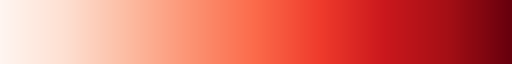

In [63]:
cmap

(np.float64(-79.16000000000001),
 np.float64(-78.61),
 np.float64(35.7),
 np.float64(36.25))

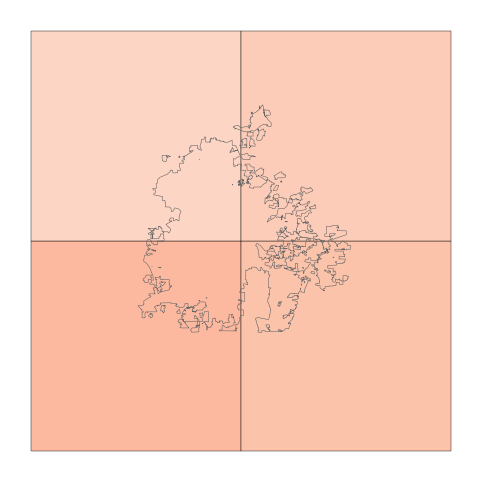

In [67]:

# Define square size (degrees)
square_size = 0.25  

# Function to plot a square
def plot_square(ax, center_lat, center_lon, size, color):
    half_size = size / 2
    # Calculate the corners of the square
    lats = [center_lat - half_size, center_lat - half_size, center_lat + half_size, center_lat + half_size, center_lat - half_size]
    lons = [center_lon - half_size, center_lon + half_size, center_lon + half_size, center_lon - half_size, center_lon - half_size]
    #ax.plot(lons, lats, 'b-')  # Plot square with blue lines
    ax.fill(lons, lats, color=color, edgecolor='black', linewidth=0.3)  # Fill square with color and outline it


# Create the plot
fig, axes = plt.subplots(figsize=(8, 6))

p = gpd.GeoSeries(shapefiles.geometry[0])

# Plot each square
for _, row in mean_max_temp_df.iterrows():
    color = scalar_mappable.to_rgba(row['era5_air_temp'])  # Map value to color
    plot_square(axes, row['era5_lat'], row['era5_lon'], square_size, color)

im1 = p.plot(linewidth=0.4, ax = axes, facecolor='none',edgecolor=".4")
axes.axis("off")


In [44]:
mean_max_temp_df

,era5_lat,era5_lon,number,d2m,era5_air_temp,shortwave_radiation,longwave_radiation,era5_rh,max_t2m
0,35.85,-79.01,0.0,20.663273,30.532461,577.472168,419.526611,57.263193,30.532461
1,35.85,-78.76,0.0,20.798021,30.487810,587.302429,420.049469,57.748639,30.487810
2,36.10,-79.01,0.0,20.567259,30.202085,577.682373,418.506744,58.033799,30.202085
3,36.10,-78.76,0.0,20.694714,30.277847,591.350098,418.730103,58.091464,30.277847


(np.float64(-79.07527510097982),
 np.float64(-78.73922287942369),
 np.float64(35.78),
 np.float64(36.22))

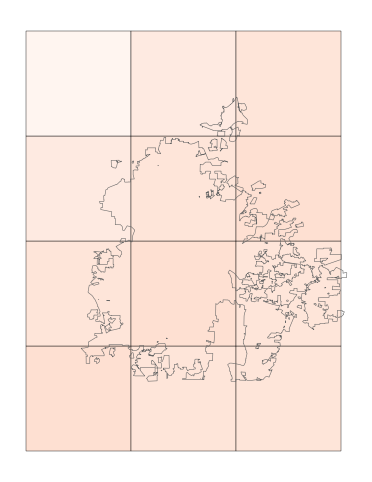

In [70]:
# Create the plot
fig, axes = plt.subplots(figsize=(8, 6))

p = gpd.GeoSeries(shapefiles.geometry[0])
#p.plot()

# Plot each square
# Define square size (degrees)
square_size = 0.1 
for _, row in era5_land_mean_max_temp_df.iterrows():
    color = scalar_mappable.to_rgba(row['era5_land_air_temp'])  # Map value to color
    plot_square(axes, row['era5_land_lat'], row['era5_land_lon'], square_size, color)
im1 = p.plot(linewidth=0.4, ax = axes, facecolor='none',edgecolor=".4")


axes.axis("off")

(np.float64(-79.00752291761101),
 np.float64(-78.7545974559852),
 np.float64(36.137016564593324),
 np.float64(35.866454997634655))

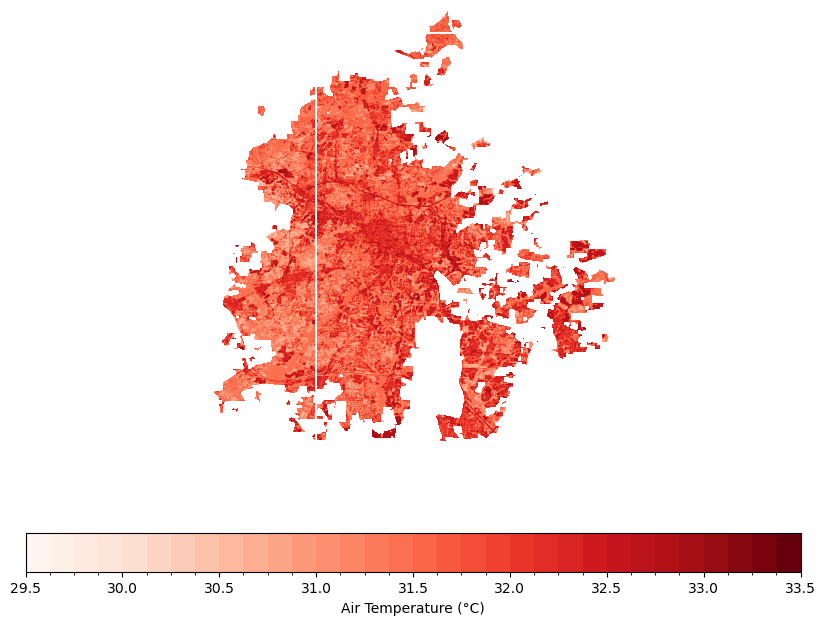

In [78]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 8))

sensor_network_tiff_filepath = r'C:\Users\UEA_Laptop\Documents\Python_Scripts\DDL\Sensor_Network\RF_max_july_aug_mean_temp_clipped.tif'
#sensor_network_tiff_filepath = r'C:\Users\UEA_Laptop\Documents\Python_Scripts\DDL\Sensor_Network\RF_max_july_aug_mean_temp.tif'
# Read the temperature raster
with rasterio.open(sensor_network_tiff_filepath) as src:
    temperature_data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs  # Coordinate Reference System

# Create a grid for plotting
height, width = temperature_data.shape
x_min, y_min = transform * (0, 0)
x_max, y_max = transform * (width, height)

x = np.linspace(x_min, x_max, width)
y = np.linspace(y_min, y_max, height)

#temperature_data, lon = add_cyclic_point(rh, coord=lon)
# translate to degC
temperature_data = 5/9*(temperature_data - 32)

# Plot the masked temperature data
im = axes.imshow(temperature_data, extent=[x_min, x_max, y_min, y_max], origin='upper', cmap=cmap, norm = norm)
fig.colorbar(im, label="Air Temperature (°C)", orientation='horizontal')
p.boundary.plot(ax=axes, color='black')  # Overlay city boundary
#plt.xlabel("Longitude")
#plt.ylabel("Latitude")
#axes.set(title="Spatially Continuous Air Temperature")

axes.axis("off")

In [73]:
temperature_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
import numpy as np
import rasterio
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt

def remove_longitude_artifact(input_tif, output_tif, artifact_longitude, lon_resolution):
    """
    Removes a line artifact at a specific longitude by adding a cyclic point.

    Parameters:
        input_tif (str): Path to the input GeoTIFF file.
        output_tif (str): Path to save the corrected GeoTIFF file.
        artifact_longitude (float): The longitude where the artifact occurs.
        lon_resolution (float): Resolution of the longitude grid in degrees.
    """
    with rasterio.open(input_tif) as src:
        data = src.read(1)  # Read the first band
        transform = src.transform
        meta = src.meta.copy()

    # Generate longitude values
    ncols = data.shape[1]
    lon_start = transform[2]
    lon_end = lon_start + (ncols * lon_resolution)
    lon = np.linspace(lon_start, lon_end - lon_resolution, ncols)

    # Add a cyclic point to the data and longitudes
    data_cyclic, lon_cyclic = add_cyclic_point(data, coord=lon, axis=1)

    # Remove the artifact by overwriting the boundary values
    data_cyclic[:, lon_cyclic == artifact_longitude] = np.nan
    data_cyclic[:, lon_cyclic == artifact_longitude] = np.nanmean(data_cyclic, axis=1)

    # Save the corrected data back to GeoTIFF
    meta.update(width=data_cyclic.shape[1], height=data_cyclic.shape[0])
    with rasterio.open(output_tif, 'w', **meta) as dst:
        dst.write(data_cyclic[:, :-1], 1)  # Remove extra cyclic column for saving

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.imshow(data, origin='upper', cmap='coolwarm', extent=[lon_start, lon_end, -90, 90])
    plt.colorbar(label="Value")
    
    plt.subplot(1, 2, 2)
    plt.title("Corrected Data")
    plt.imshow(data_cyclic[:, :-1], origin='upper', cmap='coolwarm', extent=[lon_start, lon_end, -90, 90])
    plt.colorbar(label="Value")
    
    plt.show()

# Example usage
input_tif_path = r'C:\Users\UEA_Laptop\Documents\Python_Scripts\DDL\Sensor_Network\RF_max_july_aug_mean_temp_clipped.tif'
output_tif_path = r'C:\Users\UEA_Laptop\Documents\Python_Scripts\DDL\Sensor_Network\RF_max_july_aug_mean_temp_clipped2.tif'
artifact_longitude = 180.0  # Longitude where the artifact occurs
lon_resolution = transform[0]  # Longitude resolution in degrees
remove_longitude_artifact(input_tif_path, output_tif_path, artifact_longitude, lon_resolution)


In [30]:
temperature_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [32]:
transform[0]

0.0001000100678631108

In [19]:
temperature_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [165]:
sensor_network_data

,row,col,network_lon,network_lat,network_air_temp,era5_lat,era5_lon,era5_air_temp,shortwave_radiation,longwave_radiation,era5_rh
0,21,1,-79.0158,36.1452,31.464776,36.10,-79.01,30.202085,577.682373,418.506744,58.033799
1,21,2,-79.0157,36.1452,31.405710,36.10,-79.01,30.202085,577.682373,418.506744,58.033799
2,21,3,-79.0156,36.1452,31.374249,36.10,-79.01,30.202085,577.682373,418.506744,58.033799
3,21,4,-79.0155,36.1452,31.468594,36.10,-79.01,30.202085,577.682373,418.506744,58.033799
4,21,5,-79.0154,36.1452,31.483462,36.10,-79.01,30.202085,577.682373,418.506744,58.033799
...,...,...,...,...,...,...,...,...,...,...,...
7702141,2880,2691,-78.7468,35.8593,30.602071,35.85,-78.76,30.487810,587.302429,420.049469,57.748639
7702142,2880,2692,-78.7467,35.8593,30.643977,35.85,-78.76,30.487810,587.302429,420.049469,57.748639
7702143,2880,2693,-78.7466,35.8593,31.400926,35.85,-78.76,30.487810,587.302429,420.049469,57.748639
7702144,2880,2694,-78.7465,35.8593,31.381025,35.85,-78.76,30.487810,587.302429,420.049469,57.748639


In [58]:
era5_df#['est_time']

,valid_time,latitude,longitude,number,expver,d2m,t2m,ssrd,strd,rh,est_time,Date,max_t2m
0,2024-07-01 00:00:00+00:00,36.10,-79.01,0,0001,24.695892,26.466339,1.040475e+05,1575524.875,90.013555,2024-06-30 20:00:00,2024-06-30,26.466339
1,2024-07-01 00:00:00+00:00,36.10,-78.76,0,0001,24.313690,27.053131,1.199040e+05,1575205.875,84.987012,2024-06-30 20:00:00,2024-06-30,27.053131
2,2024-07-01 00:00:00+00:00,35.85,-79.01,0,0001,24.681793,27.031525,1.233795e+05,1569738.250,86.992361,2024-06-30 20:00:00,2024-06-30,27.031525
3,2024-07-01 00:00:00+00:00,35.85,-78.76,0,0001,24.274597,27.322540,1.346320e+05,1569102.375,83.457107,2024-06-30 20:00:00,2024-06-30,27.322540
4,2024-07-01 01:00:00+00:00,36.10,-79.01,0,0001,24.817535,26.405701,1.441507e+04,1577827.250,90.995864,2024-06-30 21:00:00,2024-06-30,26.466339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,2024-08-31 22:00:00+00:00,35.85,-78.76,0,0001,21.200592,29.778107,1.152485e+06,1533725.000,60.037777,2024-08-31 18:00:00,2024-08-31,30.520355
5948,2024-08-31 23:00:00+00:00,36.10,-79.01,0,0001,21.868622,28.266327,5.518987e+05,1479283.250,68.270442,2024-08-31 19:00:00,2024-08-31,30.611664
5949,2024-08-31 23:00:00+00:00,36.10,-78.76,0,0001,22.629913,28.151154,5.085047e+05,1495317.500,71.993128,2024-08-31 19:00:00,2024-08-31,30.130524
5950,2024-08-31 23:00:00+00:00,35.85,-79.01,0,0001,22.015533,28.811981,5.614717e+05,1481266.750,66.734625,2024-08-31 19:00:00,2024-08-31,30.928802
